In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

## Load Data

In [2]:
#load signal, backgound data
vbf_events = pd.read_hdf("../MC_Prod_v12/vbf_events.hdf", "vbf") #do hdf5!!
ggf_events = pd.read_hdf("../MC_Prod_v12/ggF_events.hdf", "ggF")
qq_events = pd.read_hdf("../MC_Prod_v12/qq_all_events.hdf", "qq_all")

In [3]:
vbf_events["class"] = 1
ggf_events["class"] = 2 # need to reweight ggF better! set to 0 afterwards
qq_events["class"] = 0

In [4]:
class_weights = qq_events.weight_couplings.sum(), vbf_events.weight_couplings.sum(), ggf_events.weight_couplings.sum()
print class_weights
max(class_weights)

(60.047187373963304, 6.0885523004705586, 8.7771621167023159)


60.047187373963304

In [5]:
data = pd.concat([vbf_events, ggf_events, qq_events])
#data = pd.concat([vbf_events, ggf_events])
#print data.isnull().values.any()
#data.describe()

data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
target = data["class"]
mass = data["m4l_fsr"]
weights = data["weight_couplings"]
del data["class"]
del data["m4l_fsr"]
del data["weight_couplings"]

In [6]:
mass = mass.apply(np.log)
mass_max, mass_min = mass.max(), mass.min()
mass = (mass - mass_min)/(mass_max - mass_min) #!!! save max, min values to file
#mass.describe()
#plt.hist(mass)
#plt.show()

In [7]:
#data.head(5)

## Split Train-Test

## Reweight Events
Training: 1000x everything, fraction 1/3 VBF 1/3 ggF 1/3 qq ~~0.5 VBF, 0.25 ggF, 0.25 qq~~

Testing: Back to original VBF, ggF, qq sum of weights

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    train_test_split(data, target, mass, weights, train_size=0.75)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
 y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    mass_train.reset_index(drop=True), mass_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights_test = weights_test[y_test == 0].sum(), weights_test[y_test == 1].sum(), weights_test[y_test == 2].sum()
scale_up = 1000.
for i in xrange(3):
    weights_train[y_train == i] *= scale_up*max(class_weights)/ class_weights[i]
    weights_test[y_test == i] *= class_weights[i]/class_weights_test[i]


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum(), weights_train[y_train == 2].sum()

(45170.962616157041, 45110.29862078929, 44978.803493962521)

In [10]:
weights_test[y_test == 0].sum(), weights_test[y_test == 1].sum(), weights_test[y_test == 2].sum()

(60.047187373963304, 6.0885523004705604, 8.7771621167023142)

# Make ggF background

In [11]:
y_train[y_train == 2] = 0
y_test[y_test == 2] = 0

In [12]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model


#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':


In [ ]:
#weights_train.isnull().any()

In [ ]:
#weights_train *=1000000

In [ ]:
#weights_train.describe()

In [ ]:
#(weights_train ==0).any()

def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [13]:
D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10)
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=1) #short for testing purposes
#D.fit(X_train, y_train, nb_epoch=10) #unweighted training
#D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train)) #Only interclass weights

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
167568/167568 [==============================] - 14s - loss: 0.4131    
Epoch 2/10
167568/167568 [==============================] - 14s - loss: 0.4024    
Epoch 3/10
167568/167568 [==============================] - 14s - loss: 0.4002    
Epoch 4/10
167568/167568 [==============================] - 13s - loss: 0.3987    
Epoch 5/10
167568/167568 [==============================] - 14s - loss: 0.3970    
Epoch 6/10
167568/167568 [==============================] - 14s - loss: 0.3968    
Epoch 7/10
167568/167568 [==============================] - 14s - loss: 0.3961    
Epoch 8/10
167568/167568 [==============================] - 13s - loss: 0.3948    
Epoch 9/10
167568/167568 [==============================] - 13s - loss: 0.3950    
Epoch 10/10
167568/167568 [==============================] - 13s - loss: 0.3946    


In [ ]:
#get_class_weights(y_train)

In [ ]:
len(vbf_events), len(ggf_events), len(qq_events)

In [15]:
(y_test ==2).sum()

0

In [14]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
y_pred = y_pred.ravel()
roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
#roc_auc_score(y_true=y_test, y_score=y_pred)

0.87177427166908017

In [16]:
y_pred_train = D.predict(X_train).ravel()

In [30]:
#int_pred_test_sig = [weights_train[(y_train ==1) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
#int_pred_test_bkg = [weights_train[(y_train ==0) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

int_pred_test_sig = [weights_test[(y_test ==1) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==0) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

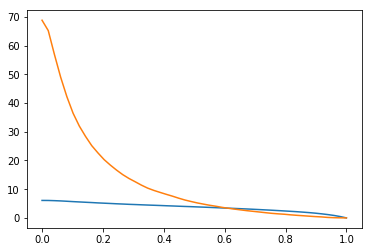

In [31]:
plt.plot(np.linspace(0,1,num=50),int_pred_test_sig)
plt.plot(np.linspace(0,1,num=50),int_pred_test_bkg)

In [32]:
from util_func import amsasimov
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
significance = max(vamsasimov)
threshold = np.linspace(0,1,num=50)[ np.array(vamsasimov).argmax() ]

In [33]:
significance, threshold

(1.7914448246513577, 0.93877551020408156)

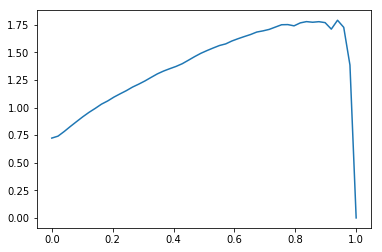

In [34]:
plt.plot(np.linspace(0,1,num=50),vamsasimov)

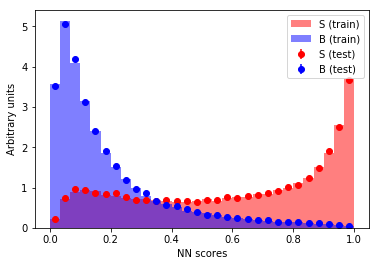

In [22]:
from util_func import compare_train_test
compare_train_test(y_pred_train, y_train, y_pred, y_test)

mass_test.describe()

plt.hist(y_pred[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")
#plt.hist(y_pred[mass_test<mass.mean()], bins=50, histtype="step", normed=1, label="Low")
#plt.hist(y_pred[mass_test>=mass.mean()], bins=50, histtype="step", normed=1, label="High")


plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

signal_low = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
signal_high = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[signal_low], weights=weights_test[signal_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[signal_high], weights=weights_test[signal_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for VBF events for low and high mass")
plt.ylim(0, 8)
plt.legend()
plt.grid()
plt.show()

bkg_low = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
bkg_high = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[bkg_low], weights=weights_test[bkg_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[bkg_high], weights=weights_test[bkg_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for background events for low and high mass")
plt.ylim(0, 4)
plt.legend()
plt.grid()
plt.show()

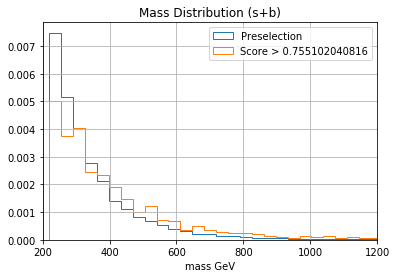

In [23]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
plt.hist(getGevMass(mass_test), weights=weights_test, bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[y_pred >= threshold]), weights=weights_test[y_pred >= threshold], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score > " + str(threshold))

plt.title("Mass Distribution (s+b)")
#plt.ylim(0, 4)
plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.legend()
plt.grid()
plt.show()

In [24]:
temp = np.zeros((len(mass_test),), dtype=[('mass',np.float64),('weight',np.float64),('NN_score',np.float64) ])
temp['mass'] = np.array(getGevMass(mass_test))
temp['weight'] = np.array(weights_test)
temp['NN_score'] = np.array(y_pred)

In [26]:
from root_numpy import array2tree
tree = array2tree(temp)

from ROOT import TEfficiency, TH1F
bins = 50
scoremin = temp['mass'].min()
scoremax = temp['mass'].max()
hpreselect = TH1F("hpreselect", "mass distribution before NN", bins, scoremin, scoremax)
hpreselect.Sumw2()
hNN = TH1F("hNN", "mass distribution for NN Score > " + str(threshold), bins, scoremin, scoremax)
hNN.Sumw2()
#tree.Project("hpreselect", "mass", "weight" ) #Tefficiency can;t do weights
tree.Project("hpreselect", "mass" )
#tree.Project("hNN", "mass", "weight*(NN_score>=" +str(threshold) + ")" )
tree.Project("hNN", "mass", "(NN_score>=" +str(threshold) + ")" )

print TEfficiency.CheckConsistency(hNN, hpreselect)
pEff = TEfficiency(hNN, hpreselect)

from ROOT import TCanvas
c = TCanvas("myCanvasName","The Canvas Title",800,350)
pEff.SetTitle("Efficiency: Pre-selection vs Post NN Selection;Mass (GeV) ;#epsilon")

True


Warning in <TROOT::Append>: Replacing existing TH1: hpreselect (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hNN (Potential memory leak).


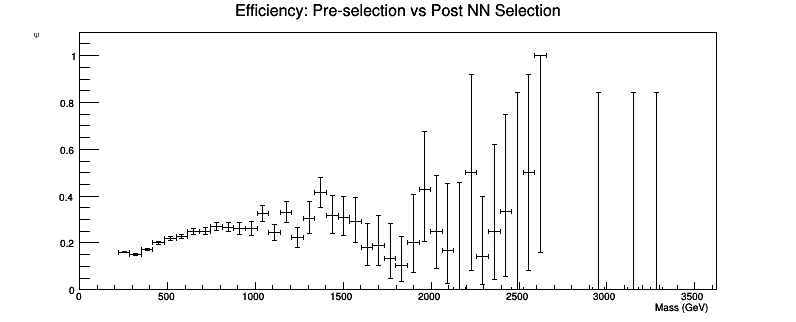

In [27]:
pEff.Draw("AP")
#ROOT.enableJSVis()
c.Draw()

plt.hist(getGevMass(mass_test[y_test==1]), weights=weights_test[y_test==1], bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[(y_test==1) & (y_pred >= threshold)]), weights=weights_test[(y_test==1) & (y_pred >= threshold)], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(round(threshold,2)))

plt.title("VBF Events")
plt.xlabel("Mass (GeV)")
#plt.ylim(0, 4)
plt.xlim(220,800 )
plt.legend()
plt.grid()
plt.show()

plt.hist(getGevMass(mass_test[y_test==0]), weights=weights_test[y_test==0], bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[(y_test==0) & (y_pred >= threshold)]), weights=weights_test[(y_test==0) & (y_pred >= threshold)], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(round(threshold,2)))

plt.title("Background Like Events (qq, ggF)")
plt.xlim(220,800 )
plt.xlabel("Mass (GeV)")
plt.legend()
plt.grid()
plt.show()

In [28]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred)
print "Unweighted correlation of all test events with mass is", corr

corr = pearsonr(mass_test[y_test ==1], y_pred[y_test ==1])
print "Unweighted correlation of signal test with mass is", corr

corr = pearsonr(mass_test[(y_pred > threshold) ], y_pred[(y_pred > threshold)])
print "Unweighted correlation of all test events passing cut with mass is", corr

Unweighted correlation of all test events with mass is (0.12988243, 1.1674226829445594e-208)
Unweighted correlation of signal test with mass is (0.065864705, 2.2424037492786485e-21)
Unweighted correlation of all test events passing cut with mass is (0.057757713, 6.9552144111583155e-09)


(y_pred>0.5).sum()/float(y_pred.shape[0]) # much better than without class_weight training

# Now with Adversarial Network

In [ ]:
def make_trainable(network, flag):
    network.trainable = flag
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_train.shape[1],))

Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

#@TODO: Gradient reversal layer, and simul training
#@TODO: loss on only the signal, we want that to be flat
Rx = Dx
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
#Rx = Dense(1, activation="sigmoid")(Rx) #try regression activations @TODO
Rx = Dense(1, activation="relu")(Rx)
R = Model(input=[inputs], outputs=[Rx])
#@TODO: loss only on background events, tanh activation, batch norm, drop out, see Andreas


In [ ]:
from keras.optimizers import SGD
from keras.losses import mean_squared_error

lam = 100.0 #10.0 # pivotal trade-off

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
        #return c * K.mean (K.binary_crossentropy(y_pred, y_true))
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * mean_squared_error(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)
#D.compile(loss="binary_crossentropy", optimizer=opt_D)

# Train D such that R loss (its c=-lam) is also minimised, make it invariant to R
#can we train simultaneous? grad reversal layer???
opt_DRf = SGD(momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
make_trainable(R, False)
make_trainable(D, True)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
make_trainable(R, True)
make_trainable(D, False)
DfR.compile(loss=[make_loss_R(c=1.0)], optimizer=opt_DfR)

In [ ]:
# Pretrain D
make_trainable(R, False)
make_trainable(D, True)
D.fit(X_train, y_train, nb_epoch=15, class_weight=get_class_weights(y_train))

In [ ]:
# Pretrain R
make_trainable(R, True)
make_trainable(D, False)
DfR.fit(X_train, mass_train, nb_epoch=7)

In [ ]:
R.evaluate(X_test, [mass_test])

In [ ]:
def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.grid()
    
    plt.show()

In [ ]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

In [ ]:
batch_size = 128
training_iterations = 50#201
for i in range(training_iterations):
    l = DRf.evaluate(X_test, [y_test, mass_test], verbose=0) #add weight!!!   
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0]) # why none, 0? just do l[1]??
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_f"][-1], losses["L_r"][-1] / lam, losses["L_r"][-1])
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    print "DRf"
    DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], class_weight=get_class_weights(y_train[indices]))
        
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    print "DfR"
    DfR.fit(X_train, mass_train, batch_size=batch_size, nb_epoch=1, verbose=1)
    #@TODO: ask andreas grand reversal layer

In [ ]:
y_pred_dc = D.predict(X_test)
y_pred_dc = y_pred_dc.ravel()
roc_auc_score(y_test, y_pred_dc, sample_weight=weights_test)

In [ ]:
plt.hist(y_pred_dc[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred_dc[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")

plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

In [ ]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred_dc)
print "Unweighted correlation with mass is", corr

In [ ]:
y_pred_dc

In [ ]:
time mass_predict = R.predict(X_test)

In [ ]:
R.evaluate(X_test, [mass_test])

In [ ]:
plt.hist(mass_predict, weights=weights_test, bins=50, histtype="step", normed=1, label="Predicted")
#plt.hist(mass_test, weights=weights_test, bins=50, histtype="step", normed=1, label="True")

#plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()
#doesnt change after adversrial training.. should get worse

In [ ]:
# @NOW: reweight ggF to be 1/4, qq 1/4 and vbf 1/2 for training only: create class_weight by hand 11
# why is the loss look decreasing further on pivot training, its not actually cuz auc is worse
# why are predictions exactly 0, 1 almost always?
# @TODO: do pivot on signal only, not background. see how Andreas did it
# loss of r is changing at a lower level, maybe subtract off the first loss? Ask Gilles,
#saw same in GAN, maybe different activation???
#just pretraining results are same as after adverserial training... even AUC is lower
#@TODO: Compare AUC with qq, without qq

In [ ]:
# @Victor:
# crossentropy and k.crossentropy differ more than by constant, even K.mean | same for Gilles, probably not big deal
# V: maybe somethinh trivial... Maybe laerning rate needs to be adjsted (sum vs mean)
# Can't train with weights, nan losses?
# V: working now.... anyway scale the weights to total no of events
# pivot not working well
# V: Try to overfit on 100 samples: find elephant
# regression activation, loss function?
# V: Its okay trial and error
# loss of r is changing at a lower level, maybe subtract off the first loss?
# V: maybe
# grad reversal layer
# V: simultaneous could be better
# why is the loss look decreasing further on pivot training, its not actually cuz auc is worse
# V: Maybe you need to let pre-training converge

!pip2 install jupyter_contrib_nbextensions